In [1]:
#importing the relevant libraries 
import numpy as np #for numerical analysis
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt #for plotting
from numba import njit #for speeding code up using 'c'

In [2]:
#constants
M_sun=1.989 * 10**30 
R_sun=695_700 *1000

## Computational Astrophysics and Geophysics Midterm 2023 Monsoon

#### Spandan Pandya: 21/20/2023. All code written in Python 

### Solving for an Unknown equation of state in the Non Relativistic Hydrostatic limit

#### Analytic form of the solution expected using dimensional analysis:

A star is in hydrostatic equilibrium when its gravitational pressure balances its outwardly pressure given by an equation of state. The equation of state for which the analysis below is done is expressed by: 

$$P_{22}=\frac{1}{3}\rho_9^{7/4}$$

Now we know that gravitational pressure is defined as: 

$$P_g=GM^{2/3}\rho^{4/3}$$

Comparing these quantities yields: 

$$M^{2/3}\rho^{4/3}\sim \rho^{7/4}$$

$$M^{2/3}\sim \rho^{5/12}$$

Using the definition of density we obtain: 

$$ M^{2/3}\sim M^{5/12}R^{-5/4}$$

$$M^{1/4}\sim R^{-5/4}$$

$$M\sim R^{-5}$$

We will try to verify this fact numerically.

##### Defining the relevant Equations

In [3]:
#equations of state
@njit
def P_22(rho): #Get Pressure as a function of density from EoS
    return (1/3*(rho*1e-9)**(7/4))*1e22 #given eos 
@njit
def P_inv(P):
    return ((3*(P*1e-22))**(4/7))*1e9 
#In order to get density at the next point using pressure we need this function as well
@njit
def dM_dr(r,rho): #first calculate mass from this equation at a given density 
    return 4*np.pi*r**2*rho #this is the first DE to solve

@njit
def dP_dr(r,M,rho): #then use that mass and density at given R to get pressure
    G = 6.674e-11 
    return -G*M*rho/r**2 #second DE (Note that this is Non relativistic)

##### Treating the problem as an IVP and Implementing RK4 

In [4]:
@njit
# This function gives all relevant information given a central density of at initial radius e
def give_data(rho0,e): #rho0 is central density 'e' is radius of small ball
    i=1 #count to begin integral loop
    init,fin=0,1e8 #We don't know the final point of integration
    # the reason we take a high value here is solely to use numba: which only works on arrays
    #and to use arrays we must define how large the list is going to be
    h=100 #step size in meters 
    N=int((fin-init)/h) #creating total steps (just to define arrays)

    rad=np.zeros(N)
    mass=np.zeros(N)
    pressure=np.zeros(N)
    rho=np.zeros(N)

    rad[0]=e #initial radius 
    rho[0]=rho0 #initial density 
    mass[0]=4*np.pi*rho[0]*e**3/3 #initial mass
    pressure[0]=P_22(rho[0]) #initial pressure using EoS

    while pressure[i-1]>0: #integrate till pressure falls to a negative value
        #note that the exact root finding is done in the next function. 
        rho[i]=P_inv(pressure[i-1]) #first find the density using initial pressure
        rad[i]=rad[i-1]+h #find radius 
        
        #RK4 coefficients for mass 
        k1m=h*dM_dr(rad[i],rho[i]) 
        k2m=h*dM_dr(rad[i]+h/2,rho[i])
        k3m=h*dM_dr(rad[i]+h/2,rho[i])
        k4m=h*dM_dr(rad[i]+h,rho[i])

        #calculate mass
        mass[i]=mass[i-1]+(k1m + 2 * k2m + 2 * k3m + k4m) / 6

        #RK4 coefficients for pressure
        k1p=h*dP_dr(rad[i],mass[i],rho[i])
        k2p=h*dP_dr(rad[i]+h/2,mass[i]+k1m/2,rho[i])
        k3p=h*dP_dr(rad[i]+h/2,mass[i]+k2m/2,rho[i])
        k4p=h*dP_dr(rad[i],mass[i]+k3m,rho[i])

        pressure[i]=pressure[i-1]+(k1p + 2 * k2p + 2 * k3p + k4p) / 6

        i+=1 #add to the step
    
    total_mass=mass[i-2]/M_sun 
    #since we stopped at the negative value the one before is the positive one: gives mass
    total_radius=rad[i-2]/1000
    #gives radius in kilometer
    
    return rad[:i-1],mass[:i-1],pressure[:i-1],rho[:i-1],total_mass,total_radius
    #gives all relevant quantities

##### Looking at the Density Profile of the star before pressure becomes negative

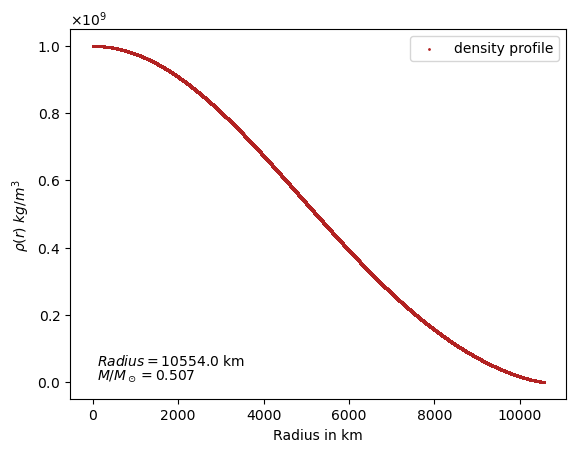

In [5]:
#For the first condition
R,M,P,density,Mt,Rt=give_data(1e9,1) #gives mass and radius  and density

#Plotting the relevant quantities
lab=r'$M /M_\odot=$'+str(np.round(Mt,3))
lab2=r'$Radius=$'+str(np.round(Rt,0))+' km'
plt.scatter(R/1000,density,s=1,c='firebrick',label='density profile')
plt.text(100,0.008e9,lab)
plt.text(100,0.05e9,lab2)

plt.xlabel('Radius in km')
plt.ylabel(r'$\rho(r)$ $kg/m^3$ ')

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

As seen by the graphs the density keeps reducing as pressure falls as well, the core has the highest density and it keeps dropping post that. 

##### Using Root Finding Methods to calculate precise radius and mass 

In summary this is what the code below does:

1) Integrates the pressure from some initial epsilon, to the point it becomes negative

2) Between the point it was positive and negative (changes sign), creates subdivisions

3) Integrates beginning from the last positive point to the negative point again, with a smaller h now. 

4) Finds pressure difference again and repeats above steps from 2

5) If it is smaller than a threshold, then stop subdividing and repeating and gives that radius and mass.

In [6]:
@njit
# This uses root finding techniques to get value 
def give_precise_data(rho0,e,h,eta): #THE QUANTITY ETA IS THE TOLERANCE FOR PRESSURE DIFFERENCE
    #h takes step length
    
    ###NOW EVERYTHING IS THE SAME AS ABOVE: UNTIL WE FIND WHERE PRESSURE GOES NEGATIVE
    i=1 
    init,fin=0,1e8
    N=int((fin-init)/h)

    rad=np.zeros(N)
    mass=np.zeros(N)
    pressure=np.zeros(N)
    rho=np.zeros(N)

    rad[0]=e
    rho[0]=rho0
    mass[0]=4*np.pi*rho[0]*e**3/3
    pressure[0]=P_22(rho[0])

    while pressure[i-1]>0:
        rho[i]=P_inv(pressure[i-1])
        rad[i]=rad[i-1]+h 
        k1m=h*dM_dr(rad[i],rho[i])
        k2m=h*dM_dr(rad[i]+h/2,rho[i])
        k3m=h*dM_dr(rad[i]+h/2,rho[i])
        k4m=h*dM_dr(rad[i]+h,rho[i])

        mass[i]=mass[i-1]+(k1m + 2 * k2m + 2 * k3m + k4m) / 6


        k1p=h*dP_dr(rad[i],mass[i],rho[i])
        k2p=h*dP_dr(rad[i]+h/2,mass[i]+k1m/2,rho[i])
        k3p=h*dP_dr(rad[i]+h/2,mass[i]+k2m/2,rho[i])
        k4p=h*dP_dr(rad[i],mass[i]+k3m,rho[i])

        pressure[i]=pressure[i-1]+(k1p + 2 * k2p + 2 * k3p + k4p) / 6

        i+=1



    total_mass=mass[i-2]/M_sun
    total_radius=rad[i-2]/1000
    
    #After this loop we know the index at which the pressure changes sign: 'i'
    # The pressure change is the change in px py 
    px,py=1e9,1e9 #some dummy index
    
    #NOW WHAT WE DO IS THE FOLLOWING: 
    
     #1) FROM POSITIVE TO NEGATIVE VALUE, CREATE SUB STEPS OF H/10
     #2) INTEGRATE THE FUNCTION IN THAT REGION 
     #3) FIND THE PRESSURE DIFFERENCE BETWEEN INITIAL AND FINAL PRESSURE AGAIN
     #4) REPEAT UNTIL IT IS LESS THAN TOLERANCE SET BY ETA
    
    r0=rad[i-2] #Integrate from the positive value 
    p0=pressure[i-2] #with the pressure at the positive value
    rho0=rho[i-2] #density at positive value 
    M0=mass[i-2] # mass at positive value 
    while abs(px+py)>eta: #repeat until P diff is less than tol
        init,fin=r0,r0+2*h #we know our root is between r0 and rf (one step length)
        i1=1 #new index 
        h=h/10 #replace h by 10 sub divisions 
        N=int((fin-init)/h)

        # NOW INTEGRATE
        rad1=np.zeros(N)
        mass1=np.zeros(N)
        pressure1=np.zeros(N)
        rho1=np.zeros(N)

        rad1[0]=r0
        rho1[0]=rho0
        mass1[0]=M0
        pressure1[0]=p0

        # RK4
        while pressure1[i1-1]>0:
            rho1[i1]=P_inv(pressure1[i1-1])
            rad1[i1]=rad1[i1-1]+h 
            k1m=h*dM_dr(rad1[i1],rho1[i1])
            k2m=h*dM_dr(rad1[i1]+h/2,rho1[i1])
            k3m=h*dM_dr(rad1[i1]+h/2,rho1[i1])
            k4m=h*dM_dr(rad1[i1]+h,rho1[i1])

            mass1[i1]=mass1[i1-1]+(k1m + 2 * k2m + 2 * k3m + k4m) / 6


            k1p=h*dP_dr(rad1[i1],mass1[i1],rho1[i1])
            k2p=h*dP_dr(rad1[i1]+h/2,mass1[i1]+k1m/2,rho1[i1])
            k3p=h*dP_dr(rad1[i1]+h/2,mass1[i1]+k2m/2,rho1[i1])
            k4p=h*dP_dr(rad1[i1],mass1[i1]+k3m,rho1[i1])

            pressure1[i1]=pressure1[i1-1]+(k1p + 2 * k2p + 2 * k3p + k4p) / 6

            i1+=1

        # Update quantities after each root iteration
        r0=rad1[i1-2]
        p0=pressure1[i1-2]
        rho0=rho1[i1-2]
        M0=mass1[i1-2]

        px,py=pressure1[i1-2],pressure1[i1-1]
        
        #give precise mass and radius and the estimated pressure difference
        
    return M0/M_sun,r0/1000,(px+py)

###### For Central Density of 1 Billion Pascals Per Meter Cubed

In [7]:
X,Y,Z=give_precise_data(1e9,1e-2,100,100)
X,Y,Z=np.round(X,4),np.round(Y,4),np.round(Z,4)
print('Mass and Radius is given by',X,'Solar Mass',Y,'km')
print('The Pressure difference was',abs(Z))

Mass and Radius is given by 0.5066 Solar Mass 10554.4165 km
The Pressure difference was 5.8898


#### Plotting Mass Radius Relationship

In [8]:
F=100
Ms=np.zeros(F)
Rs=np.zeros(F)

dens=np.linspace(1e8,1e10,F)
for j in range(F):
    Ms[j],Rs[j],_=give_precise_data(dens[j],1e-2,10,1e2)

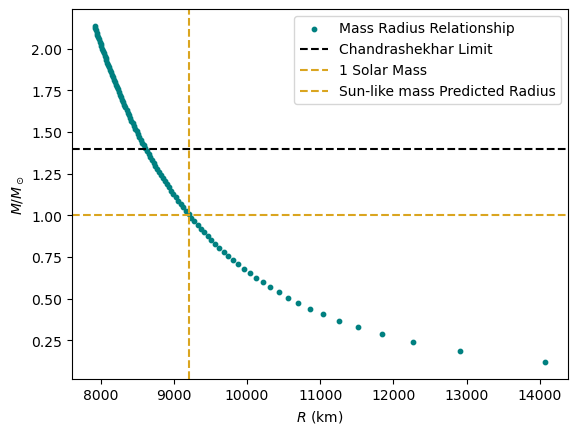

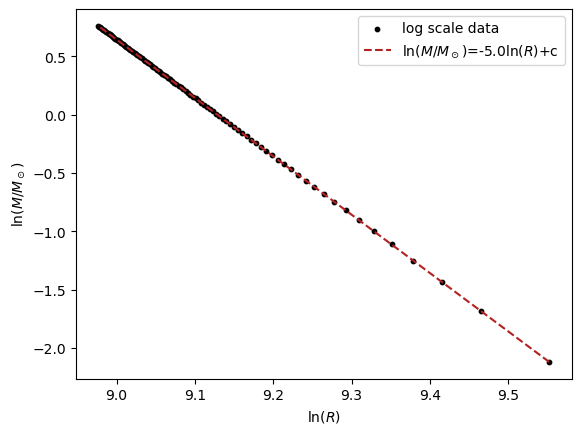

In [9]:
#Plots for mass radius relation Type A
plt.scatter(Rs,Ms,c='teal',s=10,label='Mass Radius Relationship')
plt.axhline(1.4,c='k',ls='--',label='Chandrashekhar Limit')
plt.axhline(1,c='goldenrod',ls='--',label='1 Solar Mass')
plt.axvline(Rs[29],c='goldenrod',label='Sun-like mass Predicted Radius',ls='--')
plt.ylabel(r'$M /M_\odot$')
plt.xlabel(r'$R$ (km)')
plt.legend()
plt.show()

plt.scatter(np.log(Rs),np.log(Ms),c='k',label='log scale data',s=10)
plt.ylabel(r'$\ln(M /M_\odot)$')
plt.xlabel(r'$\ln(R)$')
m,c=np.polyfit(np.log(Rs),np.log(Ms),1)
lab=r'$\ln(M /M_\odot)$='+str(np.round(m,2))+r'$\ln(R)$'+'+c'
plt.plot(np.log(Rs),m*np.log(Rs)+c,c='firebrick',ls='--',label=lab)
plt.legend()
plt.show()

In [10]:
print('For the point',np.round(Ms[29],3),'solar Mass, the radius is estimated as',np.round(Rs[29],3),'km')

For the point 1.007 solar Mass, the radius is estimated as 9200.893 km


As predicted by the analytic form discussed earlier, the power law fits the numerical data. If we look at the mass of an average solar mass star object we realise that the radius of this object should be 9200 km This indicates that the object has a radius whose order of magnitude is compable to the earth, this is true for $\textbf{White Dwarfs}$ corresponding to our equation state. Ideally we should not have masses above the chandrashekhar limit, but since this equation is different, we do not get this limit from our equation of state. 

#### Type B equation in the Non Relativistic Hydrostatic Limit

In [11]:
@njit

def P_22(rho): #Get Pressure as a function of density from EoS
    return (4*(rho*1e-18)**(5/3))*1e33 #given eos TYPE B

@njit

def P_inv(P):
    return ((1/4*(P*1e-33))**(3/5))*1e18
#In order to get density at the next point using pressure we need this function as well

@njit
# This uses root finding techniques to get value 
def give_precise_data(rho0,e,h,eta): #THE QUANTITY ETA IS THE TOLERANCE FOR PRESSURE DIFFERENCE
    #h takes step length
    
    ###NOW EVERYTHING IS THE SAME AS ABOVE: UNTIL WE FIND WHERE PRESSURE GOES NEGATIVE
    i=1 
    init,fin=0,1e8
    N=int((fin-init)/h)

    rad=np.zeros(N)
    mass=np.zeros(N)
    pressure=np.zeros(N)
    rho=np.zeros(N)

    rad[0]=e
    rho[0]=rho0
    mass[0]=4*np.pi*rho[0]*e**3/3
    pressure[0]=P_22(rho[0])

    while pressure[i-1]>0:
        rho[i]=P_inv(pressure[i-1])
        rad[i]=rad[i-1]+h 
        k1m=h*dM_dr(rad[i],rho[i])
        k2m=h*dM_dr(rad[i]+h/2,rho[i])
        k3m=h*dM_dr(rad[i]+h/2,rho[i])
        k4m=h*dM_dr(rad[i]+h,rho[i])

        mass[i]=mass[i-1]+(k1m + 2 * k2m + 2 * k3m + k4m) / 6


        k1p=h*dP_dr(rad[i],mass[i],rho[i])
        k2p=h*dP_dr(rad[i]+h/2,mass[i]+k1m/2,rho[i])
        k3p=h*dP_dr(rad[i]+h/2,mass[i]+k2m/2,rho[i])
        k4p=h*dP_dr(rad[i],mass[i]+k3m,rho[i])

        pressure[i]=pressure[i-1]+(k1p + 2 * k2p + 2 * k3p + k4p) / 6

        i+=1



    total_mass=mass[i-2]/M_sun
    total_radius=rad[i-2]/1000
    
    #After this loop we know the index at which the pressure changes sign: 'i'
    # The pressure change is the change in px py 
    px,py=1e9,1e9 #some dummy index
    
    #NOW WHAT WE DO IS THE FOLLOWING: 
    
     #1) FROM POSITIVE TO NEGATIVE VALUE, CREATE SUB STEPS OF H/10
     #2) INTEGRATE THE FUNCTION IN THAT REGION 
     #3) FIND THE PRESSURE DIFFERENCE BETWEEN INITIAL AND FINAL PRESSURE AGAIN
     #4) REPEAT UNTIL IT IS LESS THAN TOLERANCE SET BY ETA
    
    r0=rad[i-2] #Integrate from the positive value 
    p0=pressure[i-2] #with the pressure at the positive value
    rho0=rho[i-2] #density at positive value 
    M0=mass[i-2] # mass at positive value 
    while abs(px+py)>eta: #repeat until P diff is less than tol
        init,fin=r0,r0+2*h #we know our root is between r0 and rf (one step length)
        i1=1 #new index 
        h=h/10 #replace h by 10 sub divisions 
        N=int((fin-init)/h)

        # NOW INTEGRATE
        rad1=np.zeros(N)
        mass1=np.zeros(N)
        pressure1=np.zeros(N)
        rho1=np.zeros(N)

        rad1[0]=r0
        rho1[0]=rho0
        mass1[0]=M0
        pressure1[0]=p0

        # RK4
        while pressure1[i1-1]>0:
            rho1[i1]=P_inv(pressure1[i1-1])
            rad1[i1]=rad1[i1-1]+h 
            k1m=h*dM_dr(rad1[i1],rho1[i1])
            k2m=h*dM_dr(rad1[i1]+h/2,rho1[i1])
            k3m=h*dM_dr(rad1[i1]+h/2,rho1[i1])
            k4m=h*dM_dr(rad1[i1]+h,rho1[i1])

            mass1[i1]=mass1[i1-1]+(k1m + 2 * k2m + 2 * k3m + k4m) / 6


            k1p=h*dP_dr(rad1[i1],mass1[i1],rho1[i1])
            k2p=h*dP_dr(rad1[i1]+h/2,mass1[i1]+k1m/2,rho1[i1])
            k3p=h*dP_dr(rad1[i1]+h/2,mass1[i1]+k2m/2,rho1[i1])
            k4p=h*dP_dr(rad1[i1],mass1[i1]+k3m,rho1[i1])

            pressure1[i1]=pressure1[i1-1]+(k1p + 2 * k2p + 2 * k3p + k4p) / 6

            i1+=1

        # Update quantities after each root iteration
        r0=rad1[i1-2]
        p0=pressure1[i1-2]
        rho0=rho1[i1-2]
        M0=mass1[i1-2]

        px,py=pressure1[i1-2],pressure1[i1-1]
        
        #give precise mass and radius and the estimated pressure difference
        
    return M0/M_sun,r0/1000,(px+py)

In [12]:
#Adding data to lists 
Q=100
MsB=np.zeros(Q)
RsB=np.zeros(Q)

dens=np.linspace(1e17,1e20,Q)
for l in range(Q):
    MsB[l],RsB[l],_=give_precise_data(dens[l],1e-2,10,1e2)

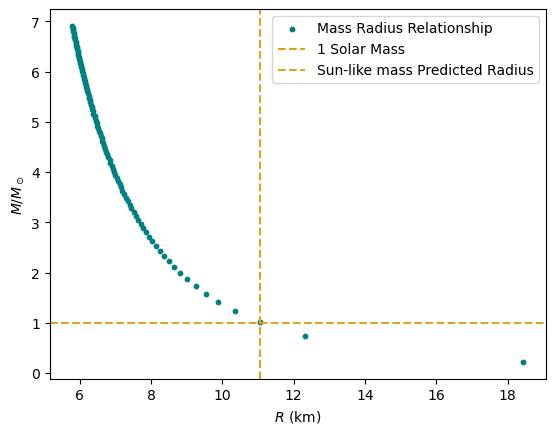

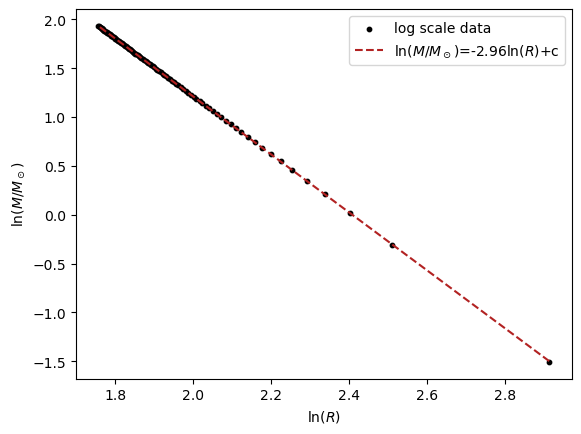

In [13]:
#Plotting the relevant quantities
plt.scatter(RsB,MsB,c='teal',s=10,label='Mass Radius Relationship')
plt.axhline(1,c='goldenrod',ls='--',label='1 Solar Mass')
plt.axvline(RsB[2],c='goldenrod',label='Sun-like mass Predicted Radius',ls='--')
plt.ylabel(r'$M /M_\odot$')
plt.xlabel(r'$R$ (km)')
plt.legend()
plt.show()

plt.scatter(np.log(RsB),np.log(MsB),c='k',label='log scale data',s=10)
plt.ylabel(r'$\ln(M /M_\odot)$')
plt.xlabel(r'$\ln(R)$')
m1,c1=np.polyfit(np.log(RsB),np.log(MsB),1)
lab=r'$\ln(M /M_\odot)$='+str(np.round(m1,2))+r'$\ln(R)$'+'+c'
plt.plot(np.log(RsB),m1*np.log(RsB)+c1,c='firebrick',ls='--',label=lab)
plt.legend()
plt.show()

From the equation of state given, and the high central densities, one can guess the object to be a $\textbf{Neutron star}$. According to the non relativistic assumption, the average radius of a neutron star with a sun like mass should be about 10-11 kilometers. The Mass radius relationship found numerically matches the one that was expected theoreteically with the slope being close to -3. The theoretical calculations are shown below: 

$$P\sim \rho^{5/3}$$

$$P_g\sim M^{2/3}\rho^{4/3}$$

Equating the two gives: 

$$M^{2/3}\sim \rho^{1/3}$$

Treating density as $M/R^3$
$$M\sim R^{-3}$$

### Relativistic Hydrostatic Equation

In [14]:
# RELEVANT PRESSURE AND DEs Listed for relativistic case
@njit
def P_33(rho):
    return (4*(rho*1e-18)**(5/3))*1e33 #given EoS
@njit
def P_inv(P):
    return (0.25*(P*1e-33))**(3/5)*1e18 #given inverse
@njit
def dP_dr(r,M,rho,P):
    G = 6.674e-11
    c2=(3*1e8)**2
    num=-G*(M+4*np.pi*r**3*P/c2)*(rho+P/c2)
    den=r**2*(1-(2*G*M)/(c2*r))
    return num/den #relativistic hydrostatic eqn DE 2
@njit
def dM_dr(r,rho):
    return 4*np.pi*r**2*rho #mass DE 1

In [15]:
@njit
#The function is the exact same as above with the change that now the pressure equation is relativistic#
def get_data(rho01,e,h,eta):
    i=1
    init,fin=0,1e8
    h=10
    N=int((fin-init)/h)
    rad=np.zeros(N)
    mass=np.zeros(N)
    pressure=np.zeros(N)
    rho=np.zeros(N)

    rad[0]=e
    rho[0]=rho01
    mass[0]=4*np.pi*rho[0]*e**3/3
    pressure[0]=P_33(rho[0])

    while pressure[i-1]>0:
        rho[i]=P_inv(pressure[i-1])
        rad[i]=rad[i-1]+h 
        k1m=h*dM_dr(rad[i],rho[i])
        k2m=h*dM_dr(rad[i]+h/2,rho[i])
        k3m=h*dM_dr(rad[i]+h/2,rho[i])
        k4m=h*dM_dr(rad[i]+h,rho[i])

        mass[i]=mass[i-1]+(k1m + 2 * k2m + 2 * k3m + k4m) / 6


        k1p=h*dP_dr(rad[i],mass[i],rho[i],pressure[i-1])
        k2p=h*dP_dr(rad[i]+h/2,mass[i]+k1m/2,rho[i],pressure[i-1])
        k3p=h*dP_dr(rad[i]+h/2,mass[i]+k2m/2,rho[i],pressure[i-1])
        k4p=h*dP_dr(rad[i],mass[i]+k3m,rho[i],pressure[i-1])

        pressure[i]=pressure[i-1]+(k1p + 2 * k2p + 2 * k3p + k4p) / 6

        i+=1
    
    
    px,py=1e9,1e9 #some dummy index
    

    
    r0=rad[i-2] #Integrate from the positive value 
    p0=pressure[i-2] #with the pressure at the positive value
    rho0=rho[i-2] #density at positive value 
    M0=mass[i-2] # mass at positive value 
    
    while abs(px+py)>eta:
        #repeat until P diff is less than tol
        init,fin=r0,r0+2*h #we know our root is between r0 and rf (one step length)
        i1=1 #new index 
        h=h/10 #replace h by 10 sub divisions 
        N=int((fin-init)/h)

        # NOW INTEGRATE
        rad1=np.zeros(N)
        mass1=np.zeros(N)
        pressure1=np.zeros(N)
        rho1=np.zeros(N)

        rad1[0]=r0
        rho1[0]=rho0
        mass1[0]=M0
        pressure1[0]=p0

        # RK4
        while pressure1[i1-1]>0:
            rho1[i1]=P_inv(pressure1[i1-1])
            rad1[i1]=rad1[i1-1]+h 
            k1m=h*dM_dr(rad1[i1],rho1[i1])
            k2m=h*dM_dr(rad1[i1]+h/2,rho1[i1])
            k3m=h*dM_dr(rad1[i1]+h/2,rho1[i1])
            k4m=h*dM_dr(rad1[i1]+h,rho1[i1])

            mass1[i1]=mass1[i1-1]+(k1m + 2 * k2m + 2 * k3m + k4m) / 6

            #NOTE THE PRESSURE AS ARGUMENT IN DPDR IS RELATIVISTIC
            k1p=h*dP_dr(rad1[i1],mass1[i1],rho1[i1],pressure1[i1-1])
            k2p=h*dP_dr(rad1[i1]+h/2,mass1[i1]+k1m/2,rho1[i1],pressure1[i1-1])
            k3p=h*dP_dr(rad1[i1]+h/2,mass1[i1]+k2m/2,rho1[i1],pressure1[i1-1])
            k4p=h*dP_dr(rad1[i1],mass1[i1]+k3m,rho1[i1],pressure1[i1-1])

            pressure1[i1]=pressure1[i1-1]+(k1p + 2 * k2p + 2 * k3p + k4p) / 6

            i1+=1

        # Update quantities after each root iteration
        r0=rad1[i1-2]
        p0=pressure1[i1-2]
        rho0=rho1[i1-2]
        M0=mass1[i1-2]

        px,py=pressure1[i1-2],pressure1[i1-1]
        
        #give precise mass and radius and the estimated pressure difference
        
    return rad[:i-1],mass[:i-1],pressure[:i-1],rho[:i-1],M0/M_sun,r0/1000,(px+py)


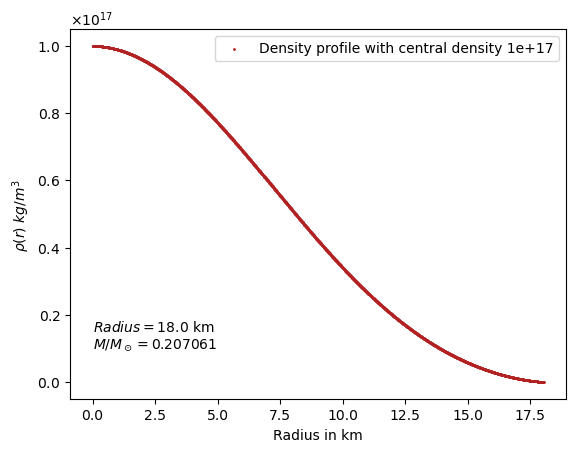

In [16]:
#density profile plots

Rrel,Mrel,Prel,densityrel,Mtrel,Rtrel,dprel=get_data(1e17,1,1000,100)
labr=r'$M /M_\odot=$'+str(np.round(Mtrel,6))
lab2r=r'$Radius=$'+str(np.round(Rtrel,0))+' km'
lab3r='Density profile with central density '+str(1e17)
plt.scatter(Rrel/1000,densityrel,s=1,c='firebrick',label=lab3r)
plt.text(0,1e16,labr)
plt.text(0,1.5e16,lab2r)

plt.xlabel('Radius in km')
plt.ylabel(r'$\rho(r)$ $kg/m^3$ ')

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

In [17]:
#appending data 
NR=200
Msr=np.zeros(NR)
Rsr=np.zeros(NR)
densr=np.linspace(1e17,1e20,NR) #GOES FROM 17 to 20 range
for ir in range(NR):
    _,_,_,_,Msr[ir],Rsr[ir],_=get_data(densr[ir],1e-2,1000,100)

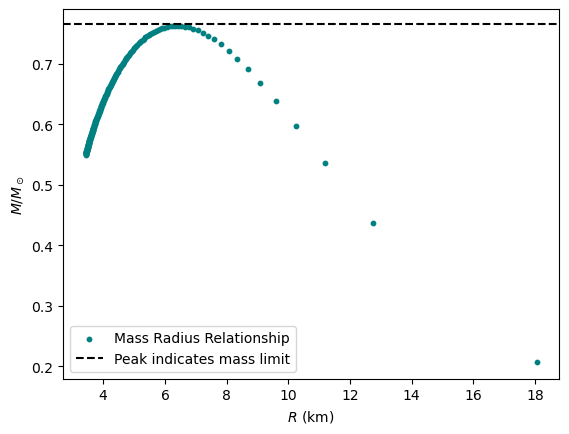

In [18]:
#Plotting mass radius relationship
plt.scatter(Rsr,Msr,c='teal',s=10,label='Mass Radius Relationship')
plt.ylabel(r'$M /M_\odot$')
plt.xlabel(r'$R$ (km)')
plt.axhline(0.765,c='k',ls='--',label='Peak indicates mass limit')
plt.legend()
plt.show()

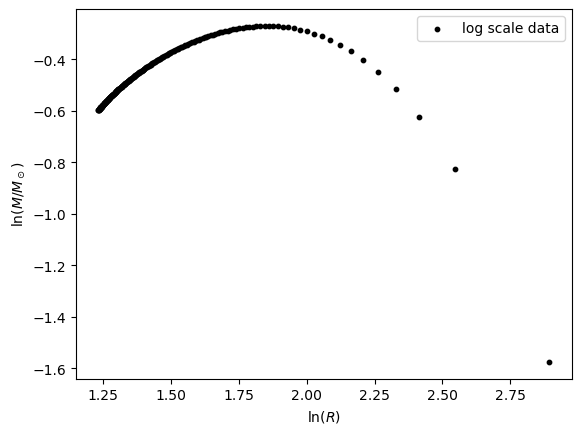

In [19]:
#Logged data
plt.scatter(np.log(Rsr),np.log(Msr),c='k',label='log scale data',s=10)
plt.ylabel(r'$\ln(M /M_\odot)$')
plt.xlabel(r'$\ln(R)$')
plt.legend()
plt.show()

The TOV equation which includes the effects of relativity gives a mass radius relationship with a Peak which is interesting. A peak in mass indicates a a limit on the maximum mass of a star. The fact that the central density of the star is so high, and the pressure falls in the 10 km to 20 km range suggests that this equation corresponds to modelling a $\textbf{Neutron Star}$. The TOV equation with GR assumption sets the upper limit of a neutron star mass to be close to $0.7M_\odot-0.8M_\odot$. If we compare it with the non relativistic case, we realise that there is no limit on the mass even tho the radii are close to one another. The inclusion of relativistic effects brings a limit to the mass. 

#### Key Takeaways from the plots

1) The non relativistic equations have no upper mass limits while the TOV equation for the neutron star does. 

2) The non relativistic equations for type A and type B were assumed to be white dwarfs and neutron stars respectively, because of their radius corresponding to 1 solar mass. 

3) The non relativistic equations all give power law mass radius relationships which match with the analytically found values. The same is not true for relativistic equations which do not follow a power law between mass and radius. 

4) All pressure solutions were integrated and bisected (to solve) until the pressure difference was less than 200 Pa. 